In [1]:
import json
import numpy
import scipy as sp
import pandas as pd
 
json_data=open('Luca_first_alarm.alrm').read()

data = json.loads(json_data)

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df=pd.read_table('profile.txt',names=['phase','t','et','bt','det','dbt'],skiprows=1)

In [4]:
df['t']=pd.to_datetime(df['t'])

In [5]:
df['seconds']=((df.t-df.t[0]).dt.total_seconds()/60).apply(int)+30

In [6]:
df.bt=df.bt.apply(int)

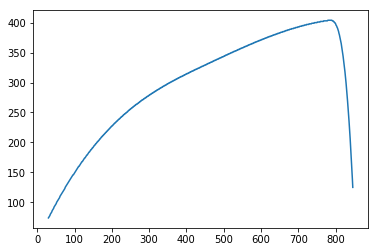

In [7]:
#profile from ryan is parsed correctly
plt.plot(df['seconds'],df['bt'])

/Users/luca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


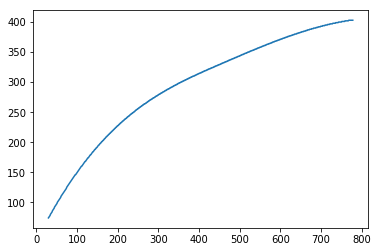

In [8]:
#we take up to the max
df=df[:df['bt'].argmax()]
plt.plot(df['seconds'],df['bt'])

In [9]:
#let's check what fields we need to fill
data.keys()

dict_keys(['alarmactions', 'alarmstrings', 'alarmconds', 'alarmnegguards', 'alarmtemperatures', 'alarmguards', 'alarmflags', 'alarmsources', 'alarmoffsets', 'alarmtimes', 'alarmbeep'])

In [10]:
#let's check the format
for key in data.keys():
    print(key,data[key])

alarmactions [16, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 13, 14]
alarmstrings ['Enter description', '330', '8', '350', '7', '406', '6', '406', '5', '430', '3', 'Enter description', 'Enter description']
alarmconds [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
alarmnegguards [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
alarmtemperatures [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
alarmguards [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
alarmflags [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
alarmsources [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
alarmoffsets [30, 30, 31, 180, 181, 330, 331, 510, 511, 630, 631, 690, 870]
alarmtimes [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
alarmbeep [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
flat_list = lambda l: [item for sublist in l for item in sublist]


In [12]:
#Let's not get the PID stressed
downsample_every=20
df=df[::downsample_every]

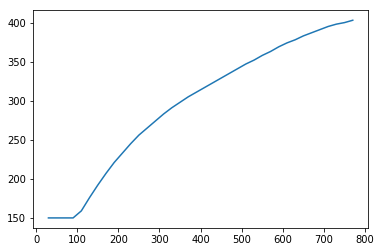

In [13]:
temp_profile=[max(150,a) for a in df.bt]
plt.plot(df.seconds,temp_profile)


In [14]:
max(temp_profile)

403

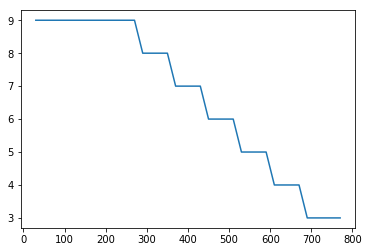

In [15]:
#we can build an arbitrary curve for the fan
fan_profile=[min(9,a) for a in np.linspace(12,3,len(df)).astype(int)]
plt.plot(df.seconds,fan_profile)


In [16]:
last_time=df.seconds.max()
seconds=df.seconds.values


In [17]:
from collections import OrderedDict

def write_artisan_alarm_profile(alarm_filename,seconds,temp_profile,fan_profile,decimate=1,preheat_time=29):
    
    profile=OrderedDict()
    if decimate>1:
        seconds=seconds[::decimate]
        temp_profile=temp_profile[::decimate]
        fan_profile=fan_profile[::decimate]


    len_profile=len(temp_profile)*2
    

    
    #alarmactions
    #16 charge
    #6 temp
    #4 fan
    #13 drop
    #14 cool end

    profile['alarmactions']=[16]+[6,4]*len(temp_profile)+[13,14]


    #alarmstrings contains the temperature and fan values, 
    #here we assume that temp and fan are alternating
    profile['alarmstrings']=list(map(str,['charge']+flat_list(list(zip(temp_profile,fan_profile)))+['drop','cool end']))


    #alarmconds always 1
    profile['alarmconds']=[1]*(len_profile+3)

    #alarmnegguards and alarmguards  and alarmtimes  -1
    profile['alarmnegguards']=[-1]*(len_profile+3)
    profile['alarmguards']=[-1]*(len_profile+3)
    profile['alarmtimes']=[-1]*(len_profile+3)

    #alarmflags and alarmsources 1
    profile['alarmflags']=[1]*(len_profile+3)
    profile['alarmsources']=[1]*(len_profile+3)

    #alarmtemperatures always 500
    profile['alarmtemperatures']=[500.0]*(len_profile+3)

    #alarmoffsets is the time, we need to add 30 for accounting the preheat phase
    last_time=max(seconds)
    profile['alarmoffsets']=list(map(int,[preheat_time]+flat_list([ (a,a) for a in seconds])+[last_time+1,last_time+1+60*3]))

    #alarmbeep always 0
    profile['alarmbeep']=[0]*(len_profile+3)
    
    json.dump(profile,open(alarm_filename,'w+'))
    

In [18]:
from collections import OrderedDict
profile=OrderedDict()
len_profile=len(df)*2


#alarmactions
#16 charge
#6 temp
#4 fan
#13 drop
#14 cool end

profile['alarmactions']=[16]+[6,4]*len(df)+[13,14]


#alarmstrings contains the temperature and fan values, 
#here we assume that temp and fan are alternating
profile['alarmstrings']=list(map(str,['charge']+flat_list(list(zip(temp_profile,fan_profile)))+['drop','cool end']))


#alarmconds always 1
profile['alarmconds']=[1]*(len_profile+3)

#alarmnegguards and alarmguards  and alarmtimes  -1
profile['alarmnegguards']=[-1]*(len_profile+3)
profile['alarmguards']=[-1]*(len_profile+3)
profile['alarmtimes']=[-1]*(len_profile+3)

#alarmflags and alarmsources 1
profile['alarmflags']=[1]*(len_profile+3)
profile['alarmsources']=[1]*(len_profile+3)

#alarmtemperatures always 500
profile['alarmtemperatures']=[500.0]*(len_profile+3)

#alarmoffsets is the time, we need to add 30 for accounting the preheat phase
last_time=max(seconds)
profile['alarmoffsets']=list(map(int,[30]+flat_list([ (a,a) for a in seconds])+[last_time+1,last_time+1+60*3]))

#alarmbeep always 0
profile['alarmbeep']=[0]*(len_profile+3)


In [19]:
json.dump(profile,open('Luca_profile_based_on_Ryan.alrm','w+'))

In [20]:
!head Luca_profile_based_on_Ryan.alrm

{"alarmactions": [16, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 13, 14], "alarmstrings": ["charge", "150", "9", "150", "9", "150", "9", "150", "9", "159", "9", "176", "9", "192", "9", "207", "9", "221", "9", "233", "9", "245", "9", "256", "9", "265", "9", "274", "8", "283", "8", "291", "8", "298", "8", "305", "7", "311", "7", "317", "7", "323", "7", "329", "6", "335", "6", "341", "6", "347", "6", "352", "5", "358", "5", "363", "5", "369", "5", "374", "4", "378", "4", "383", "4", "387", "4", "391", "3", "395", "3", "398", "3", "400", "3", "403", "3", "drop", "cool end"], "alarmconds": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [21]:
#down code to fit a log curve

In [22]:
from scipy import optimize

In [23]:
#based on Ryan's Friend
x = numpy.array([30, 390,570,750])
y = numpy.array([150, 300,350,400])

In [24]:
#log 10 should give us a good and smooth ROR decay
[a,b]=optimize.curve_fit(lambda t,a,b: a+b*np.log10(t),  x,  y)[0]

In [25]:
f_fit = lambda x: a + b*np.log10(x)

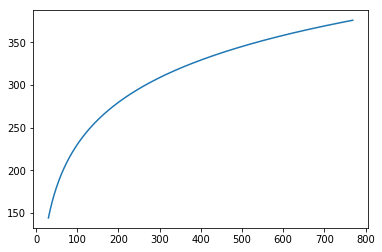

In [26]:
xi=np.arange(30,max(df.seconds),1)
plot(xi,f_fit(xi))

In [27]:
seconds=list(arange(30,750,1))
temp_profile=[max(150,a) for a in map(int,list(f_fit(seconds)))]

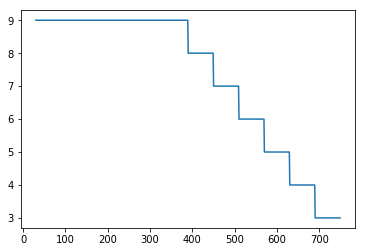

In [28]:
fan_profile=[min(9,a) for a in np.linspace(15,3,len(seconds)).astype(int)]
plt.plot(seconds,fan_profile)

In [29]:
write_artisan_alarm_profile('Luca_alarm_150_400_log10_750_sec.alrm',seconds,temp_profile,fan_profile,decimate=20)

In [30]:
!head Luca_alarm_150_400_log10_750_sec.alrm

{"alarmactions": [16, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4, 13, 14], "alarmstrings": ["charge", "150", "9", "180", "9", "204", "9", "222", "9", "236", "9", "248", "9", "259", "9", "268", "9", "275", "9", "283", "9", "289", "9", "295", "9", "301", "9", "306", "9", "310", "9", "315", "9", "319", "9", "323", "9", "327", "8", "330", "8", "334", "8", "337", "7", "340", "7", "343", "7", "346", "6", "349", "6", "351", "6", "354", "5", "356", "5", "359", "5", "361", "4", "363", "4", "366", "4", "368", "3", "370", "3", "372", "3", "drop", "cool end"], "alarmconds": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "alarmnegguards": [-1, -1, -1, -

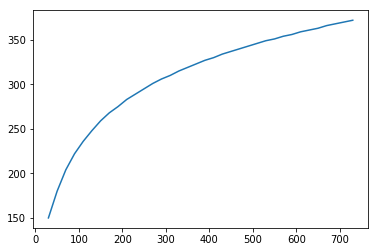

In [31]:
plt.plot(seconds[::20],temp_profile[::20])